In [2]:
using GynC
using JLD

In [4]:
@time s=JLD.load("../data/0911/allsamples.jld")["samples"]

Dict{String,Any} with 1 entry:
  "samples" => Array{Float64,2}[…

In [35]:
function rands(samplings::Vector{Matrix{Float64}}, n::Int, burnin::Int)
    res = Vector{Vector{Float64}}()
    nsamplings = length(samplings)
    for sampling in samplings
        nsamples = size(sampling, 1)
        step = floor(Int,(nsamples - burnin) / n * nsamplings)
        for i = burnin+1:step:nsamples
            push!(res, sampling[i,:])
        end
    end
    res
end

@time xs = rands(s, 1000, 100_000);
@show length(xs);

length(xs) = 1035


In [51]:
@time ys = map(x->reshape(GynC.forwardsol(x)[:,GynC.measuredinds], 31*4), xs);
@time zs = map(y->y+rand(measerr), ys);

  6.057229 seconds (27.72 M allocations: 572.286 MB, 6.01% gc time)
  0.068804 seconds (25.55 k allocations: 3.163 MB)


In [46]:
measerr = Distributions.MvNormal(repeat(GynC.model_measerrors, inner=31))

ZeroMeanDiagNormal(
dim: 124
μ: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Σ: [144.0 0.0 … 0.0 0.0; 0.0 144.0 … 0.0 0.0; … ; 0.0 0.0 … 2.25 0.0; 0.0 0.0 … 0.0 2.25]
)


In [58]:
m = GynC.LikelihoodModel(xs, ys, zs, [], measerr);

In [59]:
w0 = ones(length(xs)) / length(xs);

In [69]:
ws = GynC.mple(m, w0, 3, 1, 1)
w = ws[end];
@show sum(w);

sum(w) = 0.24999999999999967



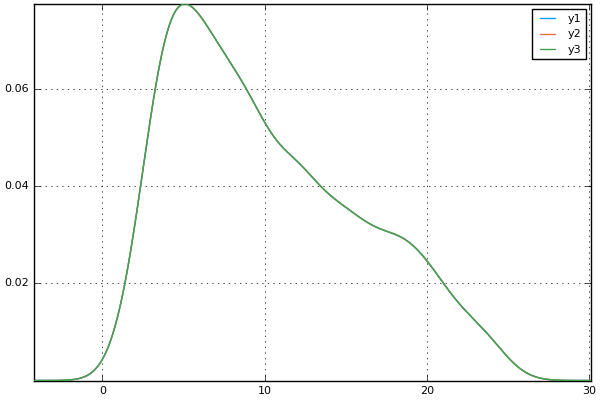

In [74]:
plot()
for w in ws
  k=kde(map(x->x[8], xs), weights=w)
  plot!(k.x, k.density)
end
plot!()

In [130]:
type MeasErr
    rhos
end

In [136]:
using Distributions
import Distributions: pdf

function pdf(m::MeasErr, delta::Matrix)
  d = 0.
  for i=1:4
    for j=1:31
      v = delta[j,i]
      v == NaN && continue
      d += pdf(m.rhos[i], v)
    end
  end
  d/(4*31)
end

d = rand(31,4)
e = MeasErr([Normal(std) for std in GynC.model_measerrors])


MeasErr(Distributions.Normal{Float64}[Distributions.Normal{Float64}(μ=12.0, σ=1.0),Distributions.Normal{Float64}(μ=1.0, σ=1.0),Distributions.Normal{Float64}(μ=40.0, σ=1.0),Distributions.Normal{Float64}(μ=1.5, σ=1.0)])

In [142]:
@time pdf(e, d)

  0.000034 seconds (501 allocations: 9.859 KB)


0.1388022005432155

In [144]:
using BenchmarkTools
@benchmark pdf(e,d)

BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  9.70 kb
  allocs estimate:  497
  minimum time:     22.21 μs (0.00% GC)
  median time:      23.74 μs (0.00% GC)
  mean time:        31.46 μs (20.56% GC)
  maximum time:     18.61 ms (99.54% GC)

In [145]:
n=Normal(1.)
@benchmark pdf(Normal(1.), 1.)

@benchmark pdf(Normal(1.), 1.)

BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     999
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  0.00 bytes
  allocs estimate:  0
  minimum time:     11.00 ns (0.00% GC)
  median time:      11.00 ns (0.00% GC)
  mean time:        11.19 ns (0.00% GC)
  maximum time:     1.75 μs (0.00% GC)